In [15]:
import numpy as np
from scipy.io import loadmat
matdat = loadmat("mnistdata.mat")
batch_data = matdat["batchdata"]
batch_targets = matdat["batchtargets"]

In [16]:
batch_size, d_in, num_batches = batch_data.shape
_, num_labels, _= batch_targets.shape

class Args():
    d_in = d_in
    batch_size = batch_size
    num_batches = num_batches
    trainset_size = batch_size*num_batches
    num_labels = num_labels
    label_strength = 1 # Hinton's "labelstrength", the strength of the layer pixel
    min_layer_softmax = 2 # Does not use hidden layers lower than this
    min_level_energy = 2 # Used for computing goodness at test time
    wc_hidden = 0.001   # Hinton's "wc" for forward weights
    wc_softmax = 0.003 # Hinton's "sup_wc" for label prediction
    lr_hidden = 0.01 # Hinton's "epsilon"
    lr_softmax = 0.1 # Hinton's "epsilonup"
    grad_smoothing = 0.9 # Hinton's "delay" variable, default=0.9
    lambda_mean = 0.03 # Peer normalization (WTF is this?)
    num_epochs = 100    # Maximum number of epochs; Hinton uses 100
    layer_dims = [d_in, 1000, 1000, 1000, num_labels] # Layer sizes for the model (always start with d_in and end with num_lables)
    num_layers = len(layer_dims)
    temp = 1 # Used for rescaling weights (Not used)
    tiny = np.exp(-50)
    dtype=np.float32 # Was trying to speed this up, doesn't help much
args = Args()

def norm_rows(x):
    # Makes the sum of squared activations be 1 per neuron
    eps = np.exp(-100,  dtype=args.dtype)
    num_comp = x.shape[1]
    # Considering using vectors of ones instead
    # Need to use keepdims for broadcasting
    return x / np.tile(eps + np.mean(x ** 2, axis=1, keepdims=True)**(0.5), (1, num_comp))

def logistic_fn(x):
    return np.divide(1, 1 + np.exp(-1*x))


def choose_from_probs(probs):
    batch_size, num_labs = probs.shape
    rands = np.random.rand(batch_size)
    choices = np.zeros(probs.shape, dtype=args.dtype)
    for n in range(batch_size):
        sum_so_far = 0
        used = 0
        for lab_idx in range(num_labs):
            sum_so_far += probs[n, lab_idx]
            if rands[n] < sum_so_far and used == 0:
                used = 1
                choices[n, lab_idx] = 1
                break
    return choices

## Setting up everything:

In [17]:
net_inputs = {}
hidden_states = {}
normed_states = {}
pos_probs = {}
neg_probs = {}
weights = {}
weights_grad = {}
biases = {}
biases_grad = {}
dC_by_din = {}
pos_ex_dC_by_dweights = {}
neg_ex_dC_by_dweights = {}
pos_ex_dC_by_dbiases = {}
neg_ex_dC_by_dbiases = {}
mean_states = {}  # Running average of hidden layers
softmax_weights = {}
softmax_weights_grad = {}

# Initialization Loop:
for layer_num in range(1, args.num_layers):
    d_in = args.layer_dims[layer_num - 1]
    d_out = args.layer_dims[layer_num]
    net_inputs[layer_num] = np.zeros([args.batch_size, d_out], dtype=args.dtype)
    # Keeping track of all the input stuff at each layer
    hidden_states[layer_num] = np.zeros([args.batch_size, d_out], dtype=args.dtype)
    normed_states[layer_num] = np.zeros([args.batch_size, d_out], dtype=args.dtype)
    pos_probs[layer_num] = np.zeros(args.batch_size, dtype=args.dtype)
    neg_probs[layer_num] = np.zeros(args.batch_size, dtype=args.dtype)
    # Keep track of the network information:
    weights[layer_num] = (1/np.sqrt(d_in,  dtype=args.dtype) * np.random.randn(d_in, d_out))
    weights_grad[layer_num] = np.zeros([d_in, d_out], dtype=args.dtype)
    biases[layer_num] = np.zeros([1, d_out], dtype=args.dtype)
    biases_grad[layer_num] = np.zeros([1, d_out], dtype=args.dtype)
    pos_ex_dC_by_dweights[layer_num] = np.zeros([d_in, d_out], dtype=args.dtype)
    neg_ex_dC_by_dweights[layer_num] = np.zeros([d_in, d_out], dtype=args.dtype)
    pos_ex_dC_by_dbiases[layer_num] = np.zeros([1, d_out], dtype=args.dtype)
    neg_ex_dC_by_dbiases[layer_num] = np.zeros([1, d_out], dtype=args.dtype)

for layer_num in range(1, args.num_layers):
    mean_states[layer_num] = 0.5*np.ones([1, args.layer_dims[layer_num]], dtype=args.dtype)
    softmax_weights[layer_num] = np.zeros([args.layer_dims[layer_num], args.num_labels], dtype=args.dtype)
    softmax_weights_grad[layer_num] = np.zeros([args.layer_dims[layer_num], args.num_labels], dtype=args.dtype)

batch_data.astype(args.dtype, copy=False)
batch_targets.astype(args.dtype, copy=False)
print("Done setting everything up")

/opt/anaconda3/envs/musicsketch/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/musicsketch/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


Train Errors Epoch 0 = 40727
Accuracy = 18.546%
Train Errors Epoch 1 = 42517
Accuracy = 14.966%
Train Errors Epoch 2 = 43267
Accuracy = 13.466%
Train Errors Epoch 3 = 43482
Accuracy = 13.036%
Train Errors Epoch 4 = 44165
Accuracy = 11.67%
Train Errors Epoch 5 = 44491
Accuracy = 11.018%
Train Errors Epoch 6 = 44505
Accuracy = 10.99%
Train Errors Epoch 7 = 44574
Accuracy = 10.852%
Train Errors Epoch 8 = 44289
Accuracy = 11.422%
Train Errors Epoch 9 = 44273
Accuracy = 11.454%


KeyboardInterrupt: 

## Main Training Loop

In [ ]:
for epoch in range(args.num_epochs):
    pos_errors = np.zeros(args.num_layers, dtype=args.dtype)
    neg_errors = np.zeros(args.num_layers, dtype=args.dtype)
    pair_sum_errors = np.zeros(args.num_layers, dtype=args.dtype)
    train_log_cost = 0
    train_errors = 0
    #  Linear decaying lr after first half of training; Hinton's "epsgain" parameter
    if epoch < args.num_epochs/2.0:
        weight_mult = 1 # This is Hinton's "epsgain" parameter
    else:
        weight_mult = (1 + 2.0*(args.num_epochs - epoch))/args.num_epochs
    for batch in range(args.num_batches):
        x = batch_data[:, :, batch]
        y = batch_targets[:, :, batch]
        # Now add the target label to the image (in the first few pixels)
        x[:, 0:args.num_labels] = args.label_strength * y
        normed_states[0] = norm_rows(x)
        for layer_num in range(1, args.num_layers - 1):
            # Forward Pass for each layer
            net_inputs[layer_num] = normed_states[layer_num - 1] @ weights[layer_num] + biases[layer_num]
            # ReLU
            relu_output = np.maximum(net_inputs[layer_num], 0)
            hidden_states[layer_num] = relu_output
            normed_states[layer_num] = norm_rows(hidden_states[layer_num])
            goodness = np.sum(hidden_states[layer_num]**2, axis=1, keepdims=True)
            # Really not sure why we are subtracting this
            pos_probs[layer_num] = (logistic_fn(goodness - (args.layer_dims[layer_num]/args.temp)))
            dC_by_din[layer_num] = np.tile(1 - pos_probs[layer_num], (1, args.layer_dims[layer_num]))*relu_output
            mean_states[layer_num] = 0.9*mean_states[layer_num] + 0.1*np.mean(relu_output, axis=0, keepdims=True)
            # Regularizer encouraging layers to turn on
            dC_by_din[layer_num] += args.lambda_mean*(np.mean(mean_states[layer_num]) - mean_states[layer_num])
            pos_ex_dC_by_dweights[layer_num] = normed_states[layer_num - 1].T @ dC_by_din[layer_num]
            pos_ex_dC_by_dbiases[layer_num] = np.sum(dC_by_din[layer_num], axis=0, keepdims=True)
        # Now get hidden states when label is neutral.  Use this to pick hard negative labels
        x[:, 0:args.num_labels] = args.label_strength * np.ones([args.batch_size, args.num_labels], dtype=args.dtype)/args.num_labels
        normed_states[0] = norm_rows(x)
        # Run the neutral data through the forward pass
        for layer_num in range(1, args.num_layers - 1):
            net_inputs[layer_num] = normed_states[layer_num - 1] @ weights[layer_num] + biases[layer_num]
            relu_output = np.maximum(net_inputs[layer_num], 0)
            hidden_states[layer_num] = relu_output
            normed_states[layer_num] = norm_rows(relu_output)
        # Looks like we use the last layer to calculate the negative data, some sort of feedback
        label_in = np.tile(biases[args.num_layers - 1], (args.batch_size, 1))
        for layer_num in range(args.min_layer_softmax, args.num_layers - 1):
            label_in += normed_states[layer_num] @ softmax_weights[layer_num]
        label_in = label_in - np.tile(np.max(label_in, axis=1, keepdims=True), (1, args.num_labels))
        unnorm_probs = np.exp(label_in)
        train_predictions = unnorm_probs/np.tile(np.sum(unnorm_probs, axis=1, keepdims=True), (1, args.num_labels))
        correct_probs = np.sum(train_predictions*y, axis=1, keepdims=True) # Should be a Column vector
        curr_train_log_cost = -1 * np.log(args.tiny + correct_probs)
        train_log_cost += np.sum(curr_train_log_cost)/args.num_batches
        train_guesses = np.argmax(train_predictions, axis=1)
        target_indices = np.argmax(y, axis=1)
        train_errors += np.sum(train_guesses != target_indices)
        # Now do the backprop step
        dC_by_din[args.num_layers] = y - train_predictions
        # Not used:
        # dC_by_dbiases = sum(dC_by_din[args.num_layers], axis=0)
        for layer_num in range(args.min_layer_softmax, args.num_layers):
            dC_by_softmax_weights = normed_states[layer_num].T @ dC_by_din[args.num_layers]
            softmax_weights_grad[layer_num] = args.grad_smoothing * softmax_weights_grad[layer_num] + (1 - args.grad_smoothing)*dC_by_softmax_weights/args.batch_size
            softmax_weights[layer_num] += weight_mult*args.lr_softmax*(softmax_weights_grad[layer_num] - args.wc_softmax*softmax_weights[layer_num])
        # Make Negative Data
        neg_data = x
        # Big negative logits
        label_in_others = label_in - 1000*y
        neg_data[:, :args.num_labels] = args.label_strength*choose_from_probs(np.exp(label_in_others)/sum(np.exp(label_in_others)))
        normed_states[0] = norm_rows(neg_data)
        for layer_num in range(1, args.num_layers - 1):
            net_inputs[layer_num] = normed_states[layer_num - 1] @ weights[layer_num] + biases[layer_num]
            relu_output = np.maximum(net_inputs[layer_num], 0)
            hidden_states[layer_num] = relu_output
            normed_states[layer_num] = norm_rows(relu_output)
            goodness = np.sum(hidden_states[layer_num]**2, axis=1, keepdims=True)
            # Really not sure why we are subtracting this
            neg_probs[layer_num] = (logistic_fn(goodness - (args.layer_dims[layer_num]/args.temp)))
            dC_by_din[layer_num] = np.tile(-1*neg_probs[layer_num], (1, args.layer_dims[layer_num]))*relu_output
            neg_ex_dC_by_dweights[layer_num] = normed_states[layer_num - 1].T @ dC_by_din[layer_num]
            neg_ex_dC_by_dbiases[layer_num] = np.sum(dC_by_din[layer_num], axis=0, keepdims=True)
            pair_sum_errors[layer_num] += np.sum(neg_probs[layer_num] > pos_probs[layer_num])
        # Gradient Backprop (FINALLY)
        for layer_num in range(1, args.num_layers - 1):
            dC_by_dW = (pos_ex_dC_by_dweights[layer_num] + neg_ex_dC_by_dweights[layer_num])/args.batch_size
            weights_grad[layer_num] = args.grad_smoothing*weights_grad[layer_num] + (1 - args.grad_smoothing)*(dC_by_dW)
            
            dC_by_dB = (pos_ex_dC_by_dbiases[layer_num] + neg_ex_dC_by_dbiases[layer_num])/args.batch_size
            biases_grad[layer_num] = args.grad_smoothing*biases_grad[layer_num] + (1 - args.grad_smoothing)*dC_by_dB
            biases[layer_num] += args.lr_hidden*weight_mult*biases_grad[layer_num]
            weights[layer_num] += args.lr_hidden*weight_mult*(weights_grad[layer_num] - args.wc_hidden*weights[layer_num])
    print(f"Train Errors Epoch {epoch} = {train_errors}")
    print(f"Accuracy = {100.0*(args.trainset_size-train_errors)/(1.0*args.trainset_size)}%")
print(f"Donesies Train Errors = {train_errors}")
print(f"Accuracy = {100.0*(args.trainset_size-train_errors)/(1.0*args.trainset_size)}%")

### For viewing the images

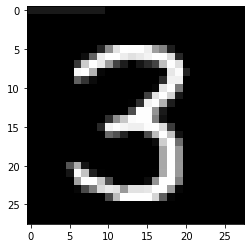

In [18]:
import matplotlib.pyplot as plt
plt.imshow(x[3, :].reshape(28, 28), cmap='gray')